In [1]:
# Import libraries
import keras
import os
from keras import backend as k
import numpy as np
import matplotlib.pyplot as plt
import pickle
import seaborn as sns
import pandas as pd
from pathlib import Path
import tensorflow as tf
import dask
import dask.array as da
import xarray as xr
import keras_tuner

2024-01-25 15:20:41.203721: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-25 15:20:41.232052: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Set Keras backend for image data format
keras.backend.set_image_data_format('channels_last')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

## Converting npz to zarr for lazy loading

In [3]:
# data_dir = Path('../../../data/foresttree/')
# file_list = list(data_dir.glob('*.npz'))
# file_list.sort()

# # Initialize a Zarr group
# zarr_dir = Path('./foresttree.zarr')

# # Append other files
# for file in file_list:
#     print(f"adding file {file}")
#     data = np.load(file)
#     ds = xr.Dataset(data_vars=dict(
#         X = (['sample', 'x', 'y', 'channel'], data['X']),
#         Y = (['sample'], data['Y']),
#     ),)
#     print(f"number of samples: {len(ds.sample)}")
#     if zarr_dir.exists():
#         ds.to_zarr(zarr_dir, append_dim='sample') 
#     else:
#         ds.to_zarr(zarr_dir)  


## Make training dataset and save to zarr

In [4]:
# data = xr.open_zarr('../../../data/foresttree/foresttree.zarr/')
# data

In [5]:
# # Statistics on the classes. Noe that we only have 3 classes
# print(np.unique(data['Y'])) # 1 for bananas, 2 for cacao, 4 for fruit
# data['Y'].plot.hist()

In [6]:
# def generate_train_image_pairs(images_dataset, labels_dataset):
#     """Function to generate image pairs for training

#     Parameters
#     ----------
#     images_dataset : image dataset
#         Xarray DataArray containing the images, can be dask array
#     labels_dataset : label dataset
#         NumPy array for simplicity
#     """
#     unique_labels = np.unique(labels_dataset)
#     label_wise_indices = dict()
#     label_wise_samples = dict()
#     for label in unique_labels:
#         label_wise_indices.setdefault(label,
#                                       [index for index, curr_label in enumerate(labels_dataset) if
#                                        label == curr_label])
#     samples = {key: len(value) for key, value in label_wise_indices.items()}
#     for i in label_wise_indices.keys():
#         label_wise_samples[i] = label_wise_indices[i][0:min(samples.values())] 

#     pair_images = []
#     pair_labels = []
#     pair_index = []
#     for index, image in enumerate(images_dataset):
#         if index in np.ndarray.flatten(np.array(([*label_wise_samples.values()]))):
#             pos_indices = label_wise_samples.get(labels_dataset[index])
#             pos_index = np.random.choice(pos_indices)
#             pos_image = images_dataset[pos_index]
#             pair = xr.concat([image.expand_dims(pair=1), pos_image.expand_dims(pair=1)], dim='pair') # add pair dimension
#             pair_images.append(pair.expand_dims(sample=1)) # add sample dimension

#             pair_labels.append(1)
#             pair_index.append((index,pos_index))

#             neg_indices = np.setdiff1d(np.ndarray.flatten(np.array(([*label_wise_samples.values()]))), pos_indices)
#             neg_index = np.random.choice(neg_indices)
#             neg_image = images_dataset[neg_index]
#             pair = xr.concat([image.expand_dims(pair=1), neg_image.expand_dims(pair=1)], dim='pair')
#             pair_images.append(pair.expand_dims(sample=1))
#             pair_index.append((index,neg_index))
#             pair_labels.append(0)
#         else:
#             continue
        
#     return xr.concat(pair_images, dim='sample'), np.array(pair_labels), np.array(pair_index)

In [7]:
# images_pair, labels_pair, index_pair = generate_train_image_pairs(data['X'], data['Y'].to_numpy())

In [8]:
# ds_images_pair = images_pair.to_dataset()
# ds_images_pair = ds_images_pair.assign(Y = (['sample'], labels_pair))
# ds_images_pair = ds_images_pair.assign(index_pair = (['sample', 'pair'], index_pair))
# ds_images_pair

In [9]:
# ds_images_pair.to_zarr('training_data.zarr', mode='w')

## Model training

In [10]:
data = xr.open_zarr('../../../data/foresttree/training_data.zarr/')
data

<xarray.Dataset>
Dimensions:     (sample: 2592, pair: 2, x: 400, y: 400, channel: 3)
Dimensions without coordinates: sample, pair, x, y, channel
Data variables:
    X           (sample, pair, x, y, channel) float32 dask.array<chunksize=(1, 1, 100, 100, 1), meta=np.ndarray>
    Y           (sample) int64 dask.array<chunksize=(2592,), meta=np.ndarray>
    index_pair  (sample, pair) int64 dask.array<chunksize=(2592, 2), meta=np.ndarray>

In [11]:
# Take 10 samples
images_pair = data['X'][:10].to_numpy()
labels_pair = data['Y'][:10].to_numpy()

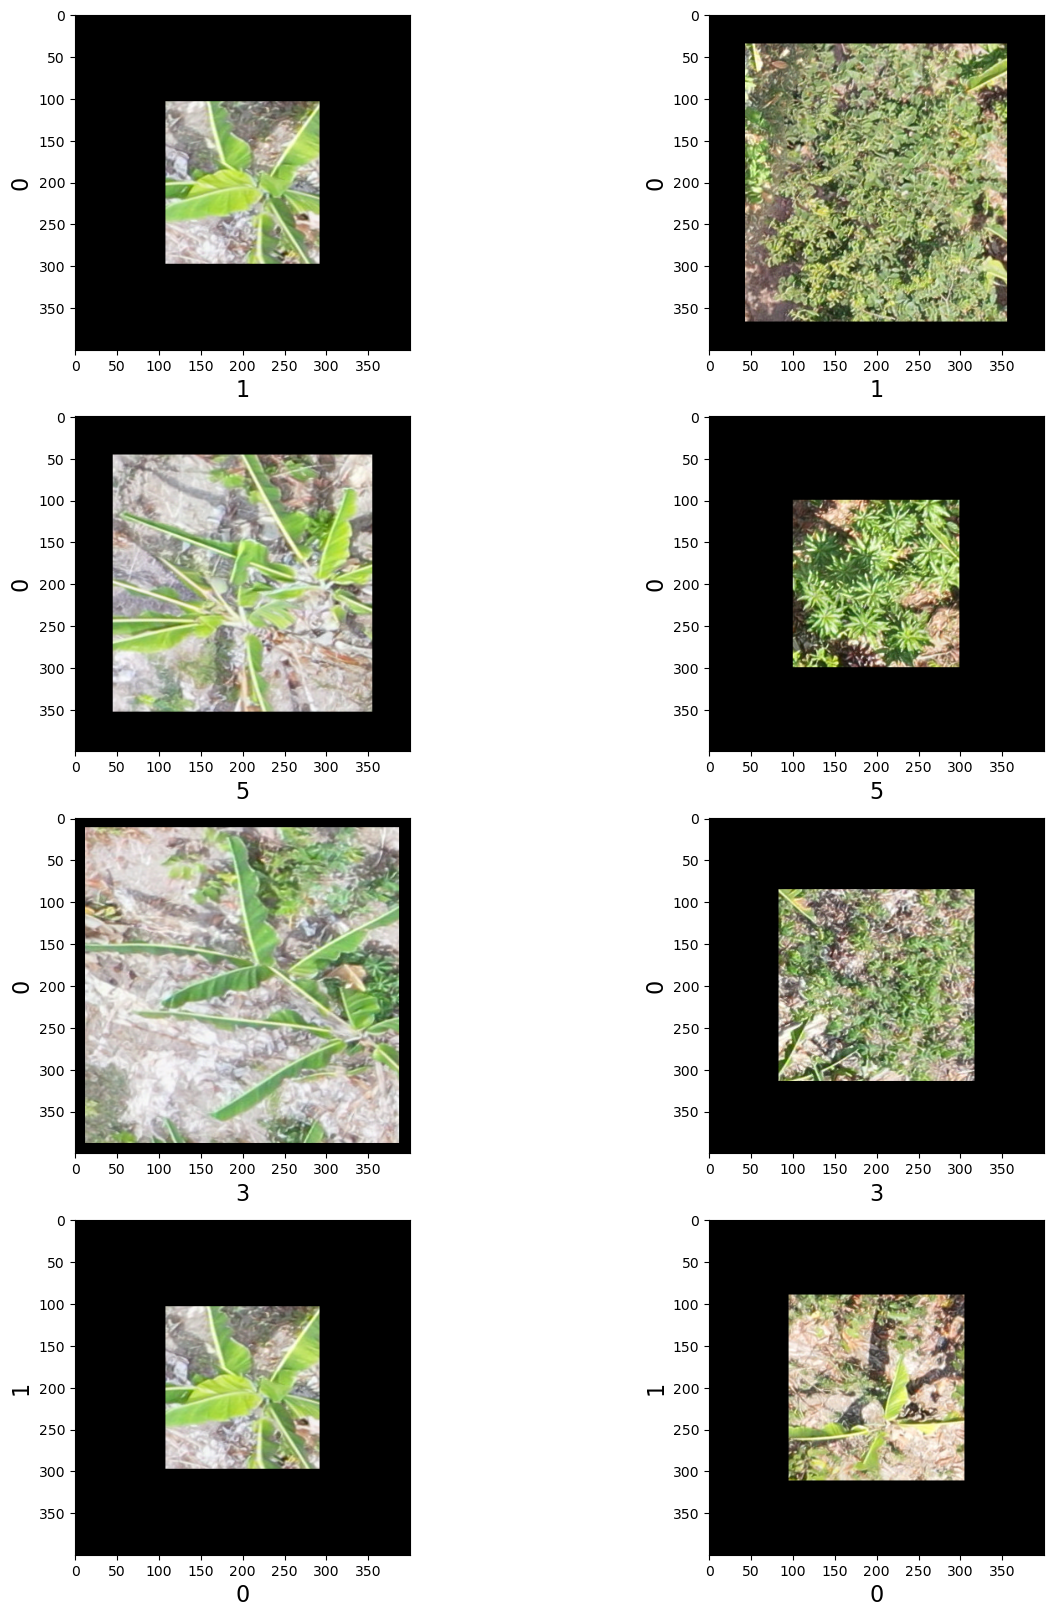

In [12]:
fig = plt.figure(figsize=(15, 20))
j = 0
for i in range(4):
    # idx = np.random.randint(6624)
    sub = fig.add_subplot(4, 2, j + 1)
    j = j+1
    idx = np.random.randint(images_pair.shape[0])
    # sub.imshow(images_pair[idx,0,:,:,:].transpose(1,2,0).astype('int'))
    sub.imshow(images_pair[idx,0,:,:,:].astype('int'))
    sub.set_ylabel(labels_pair[idx], fontsize=16)
    sub.set_xlabel(idx, fontsize=16)
    sub = fig.add_subplot(4, 2, j + 1)
    j = j+1
    # sub.imshow(images_pair[idx,1,:,:,:].transpose(1,2,0).astype('int'))
    sub.imshow(images_pair[idx,1,:,:,:].astype('int'))
    sub.set_ylabel(labels_pair[idx], fontsize=16)
    sub.set_xlabel(idx, fontsize=16)

plt.show(block=True)

## Model setup and tunning

In [15]:
# Set up model with auto tuner
nneurons_choices = [32, 64, 128]
nfilters_choices = [3,5,7]
ndropout_choices = [0.3]
npool_choices = [2]


def _create_model(hp):
    inputs = keras.Input((400, 400, 3))
    x = keras.layers.Conv2D(
        hp.Choice("nneurons1", nneurons_choices),
        (hp.Choice("nfilters1", nfilters_choices), hp.Choice("nfilters1", nfilters_choices)),
        padding="same",
        activation="relu",
    )(inputs)
    x = keras.layers.MaxPooling2D(
        pool_size=hp.Choice("npool1", npool_choices), data_format="channels_last"
    )(x)
    x = keras.layers.Dropout(hp.Choice("ndropout1", ndropout_choices))(x)

    x = keras.layers.Conv2D(
        hp.Choice("nneurons2", nneurons_choices),
        (hp.Choice("nfilters2", nfilters_choices), hp.Choice("nfilters2", nfilters_choices)),
        padding="same",
        activation="relu",
    )(x)
    x = keras.layers.MaxPooling2D(
        pool_size=hp.Choice("npool2", npool_choices), data_format="channels_last"
    )(x)
    x = keras.layers.Dropout(hp.Choice("ndropout2", ndropout_choices))(x)

    x = keras.layers.Conv2D(
        hp.Choice("nneurons3", nneurons_choices),
        (hp.Choice("nfilters3", nfilters_choices), hp.Choice("nfilters3", nfilters_choices)),
        padding="same",
        activation="relu",
    )(x)
    x = keras.layers.MaxPooling2D(
        pool_size=hp.Choice("npool3", npool_choices), data_format="channels_last"
    )(x)
    x = keras.layers.Dropout(hp.Choice("ndropout3", ndropout_choices))(x)

    pooledOutput = keras.layers.GlobalAveragePooling2D()(x)
    pooledOutput = keras.layers.Dense(hp.Choice("nneurons4", [128, 256]))(pooledOutput)
    outputs = keras.layers.Dense(hp.Choice("nneurons5", [32, 64, 128]))(pooledOutput)

    model = keras.Model(inputs, outputs)
    return model


def _euclidean_distance(vectors):
    (featA, featB) = vectors
    sum_squared = k.sum(k.square(featA - featB), axis=1, keepdims=True)
    return k.sqrt(k.maximum(sum_squared, k.epsilon()))


def siamese_model(hp):
    feature_extractor_model = _create_model(hp)
    imgA = keras.Input(shape=(400, 400, 3))
    imgB = keras.Input(shape=(400, 400, 3))
    featA = feature_extractor_model(imgA)
    featB = feature_extractor_model(imgB)
    distance = keras.layers.Lambda(_euclidean_distance)([featA, featB])
    outputs = keras.layers.Dense(1, activation="sigmoid")(distance)
    model = keras.Model(inputs=[imgA, imgB], outputs=outputs)
    
    opt = keras.optimizers.Adam(learning_rate=0.01)
    model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])
    
    return model

In [20]:
tuner = keras_tuner.Hyperband(siamese_model,
                    objective='val_accuracy',
                    max_epochs=10,
                    factor=3,
                    directory='./results_dir',
                    )

In [32]:
tuner.search([images_pair[:,0], images_pair[:,1]], labels_pair[:], epochs=5, validation_split=0.2)

Trial 19 Complete [00h 00m 33s]
val_accuracy: 0.5

Best val_accuracy So Far: 1.0
Total elapsed time: 00h 14m 21s

Search: Running Trial #20

Value             |Best Value So Far |Hyperparameter
128               |128               |nneurons1
5                 |3                 |nfilters1
2                 |2                 |npool1
0.3               |0.3               |ndropout1
128               |64                |nneurons2
5                 |3                 |nfilters2
2                 |2                 |npool2
0.3               |0.3               |ndropout2
32                |32                |nneurons3
7                 |3                 |nfilters3
2                 |2                 |npool3
0.3               |0.3               |ndropout3
128               |128               |nneurons4
128               |128               |nneurons5
4                 |4                 |tuner/epochs
0                 |0                 |tuner/initial_epoch
1                 |1              

KeyboardInterrupt: 

In [34]:
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

In [38]:
model = tuner.hypermodel.build(best_hps)
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_8 (InputLayer)        [(None, 400, 400, 3)]        0         []                            
                                                                                                  
 input_9 (InputLayer)        [(None, 400, 400, 3)]        0         []                            
                                                                                                  
 model_4 (Functional)        (None, 128)                  116576    ['input_8[0][0]',             
                                                                     'input_9[0][0]']             
                                                                                                  
 lambda_2 (Lambda)           (None, 1)                    0         ['model_4[0][0]',       

## Model training

In [40]:
history = model.fit([images_pair[:,0], images_pair[:,1]], labels_pair[:], epochs=5, validation_split=0.2)

Epoch 1/5
1/1 [==============================] - 12s 12s/step - loss: 46.1992 - accuracy: 0.5000 - val_loss: 0.7445 - val_accuracy: 0.5000
Epoch 2/5
1/1 [==============================] - 10s 10s/step - loss: 1.7783 - accuracy: 0.5000 - val_loss: 0.6927 - val_accuracy: 0.5000
Epoch 3/5
1/1 [==============================] - 8s 8s/step - loss: 0.7059 - accuracy: 0.5000 - val_loss: 0.6848 - val_accuracy: 0.5000
Epoch 4/5
1/1 [==============================] - 8s 8s/step - loss: 0.6325 - accuracy: 0.5000 - val_loss: 0.4047 - val_accuracy: 0.5000
Epoch 5/5
1/1 [==============================] - 7s 7s/step - loss: 5.4210 - accuracy: 0.5000 - val_loss: 0.6916 - val_accuracy: 0.5000


In [41]:
model.save_weights('optimized_weights_10imgs_batch.h5')

with open('./trainHistoryDict_10imgs_batch.pikl', 'wb') as file_pi:
    pickle.dump(history, file_pi)

## Prediction and Result Analysis

In [42]:
labels_pred = model.predict([images_pair[:10, 0], images_pair[:10, 1]])

1/1 [==============================] - 1s 1s/step


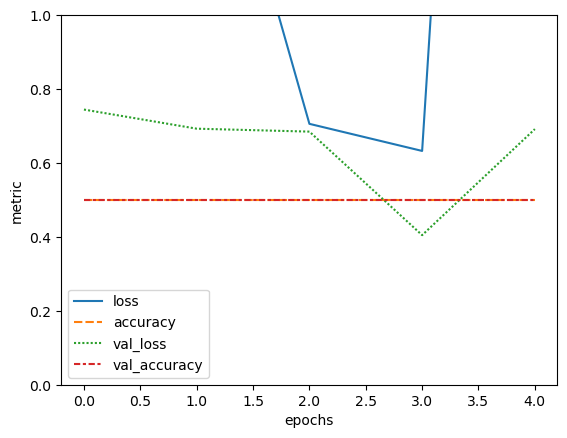

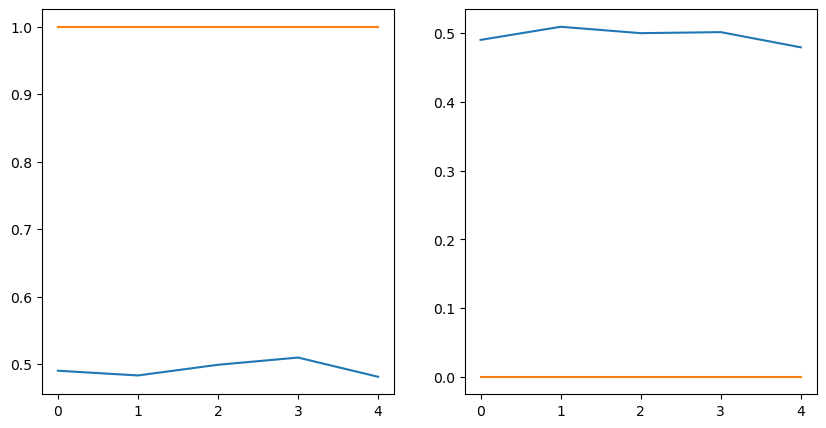

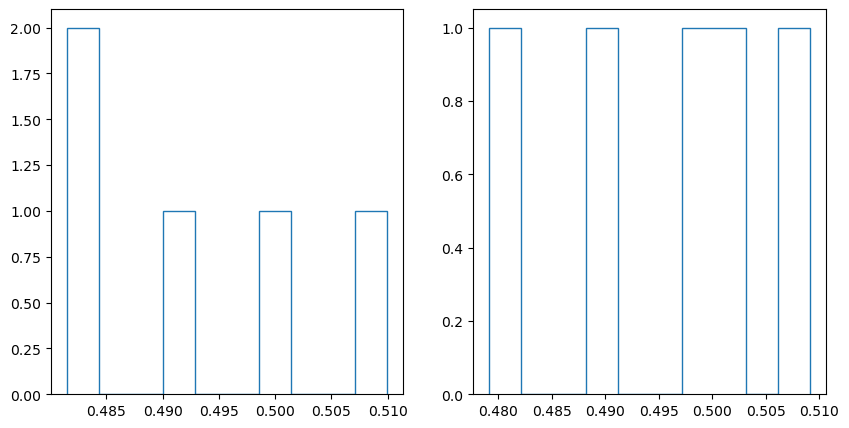

In [43]:
def plot_history(history, metrics):
    """
    Plot the training history

    Args:
        history (keras History object that is returned by model.fit())
        metrics (str, list): Metric or a list of metrics to plot
    """
    history_df = pd.DataFrame.from_dict(history.history)
    sns.lineplot(data=history_df[metrics])
    plt.xlabel("epochs")
    plt.ylabel("metric")
    plt.ylim(0, 1)

plot_history(history, ['loss', 'accuracy', 'val_loss', 'val_accuracy'] )

fig = plt.figure(figsize=(10, 5))

sub = fig.add_subplot(1, 2, 1)
sub.plot(labels_pred[::2])
# sub.plot(np.round(labels_pred[::2]))
sub.plot(labels_pair[::2])

sub = fig.add_subplot(1, 2, 2)
sub.plot(labels_pred[1::2])
# sub.plot(np.round(labels_pred[1::2]))
sub.plot(labels_pair[1::2])

fig2 = plt.figure(figsize=(10, 5))

counts, bins = np.histogram(labels_pred[::2])
sub = fig2.add_subplot(1, 2, 1)
sub.stairs(counts, bins)
# sub.plot(np.round(labels_pred[::2]))
# sub.plot(labels_pair[::2])

sub = fig2.add_subplot(1, 2, 2)
counts, bins = np.histogram(labels_pred[1::2])
sub.stairs(counts, bins)
# sub.plot(np.round(labels_pred[1::2]))
# sub.plot(labels_pair[1::2])